# Timsort vs Powersort

## Preliminaries

2023-03-20 Confirmed that the PyPy implementations of Timsort and Powersort
yield the same comparison counts as the CPython implementations.


NB: Careful, when checking this we need to run the sorting call of the list through the
instrumented cpython copies with print debug enabled, by then we have to run `run_information.py`
through the copy of cpython that does *not* print debug info
(as the rank reduction induces extra comparisons),
but we must use the correct sort implementation to get the correct comparison count.

But, long story short, we can use the following two implementations for our purposes,
as they yielded identical results.


In [1]:
%load_ext autoreload
%autoreload 2
import Support.Counters as Counters
import PyPySorters.listsort_powersort
import PyPySorters.listsort_timsort
import random

random.seed(2348905739)
A = list(range(10000))
random.shuffle(A)

C = [Counters.ComparisonCounter(x) for x in A]
print("Running Powersort")
Counters.reset_counters()
PyPySorters.listsort_powersort.sort(C)
Counters.print_counters()
C = [Counters.ComparisonCounter(x) for x in A]
print("Running Timsort")
Counters.reset_counters()
PyPySorters.listsort_timsort.sort(C)
Counters.print_counters()


Running Powersort
Comparisons: 119877
Eq Comparisons: 0
MergeCosts: 79760
Running Timsort
Comparisons: 119954
Eq Comparisons: 0
MergeCosts: 79840


## Experiments

Now for a more systematic approach.

### Init:

In [2]:
%load_ext autoreload
%autoreload 2
import random
import pandas as pd
import matplotlib.pylab as plt

import PyPySorters.listsort_powersort as powersort
import PyPySorters.listsort_timsort as timsort
import Support.Counters as Counters
import Inputs.Inputs as Inputs



def cost(lst, sorter):
    wrapped = [Counters.ComparisonCounter(x) for x in lst]
    Counters.reset_counters()
    sorter.sort(wrapped)
    assert Counters.ComparisonCounter.EQ_COMPARISONS == 0
    return {
        # 'algo': sorter.name(),
        'mc': Counters.MergeCosts.MERGECOST,
        'cmps': Counters.ComparisonCounter.COMPARISONS,
        'input-hash': hash(tuple(lst)),
    }


def differences(repetitions, input_generator):
    diffs = pd.DataFrame()
    for _ in range(repetitions):
        A = input_generator()
        ps = cost(A, powersort)
        ts = cost(A, timsort)
        diff = {}
        diff['algo'] = 'timsort-powersort'
        diff['mc'] = 1.0 * ts['mc'] - ps['mc']
        diff['cmps'] = 1.0 * ts['cmps'] - ps['cmps']
        diff['mc-powersort'] = ps['mc']
        diff['cmps-powersort'] = ps['cmps']
        diff['input-hash'] = ps['input-hash']
        diffs = diffs.append(diff, ignore_index=True)
    return diffs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Random Permutations

For random permutations, not too much is saved,
but at least we hard do worse.


In [3]:
n = 10000
sqrtn = int(n ** 0.5)
reps = 200

RNG = random.Random(2348905734)
diffs = differences(reps, lambda: Inputs.random_permutation(n, RNG))
#print(diffs)
print(diffs['mc']  .describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75]))
print(diffs['cmps'].describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75]))

count    200.0
mean      80.0
std        0.0
min       80.0
1%        80.0
5%        80.0
10%       80.0
25%       80.0
50%       80.0
75%       80.0
max       80.0
Name: mc, dtype: float64
count    200.000000
mean      79.815000
std       24.791609
min       16.000000
1%        27.950000
5%        41.950000
10%       48.000000
25%       63.000000
50%       78.000000
75%       96.250000
max      152.000000
Name: cmps, dtype: float64


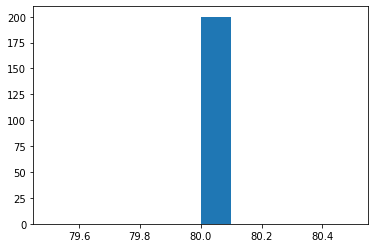

(array([ 4.,  8., 28., 31., 49., 34., 26., 11.,  7.,  2.]),
 array([ 16. ,  29.6,  43.2,  56.8,  70.4,  84. ,  97.6, 111.2, 124.8,
        138.4, 152. ]),
 <a list of 10 Patch objects>)

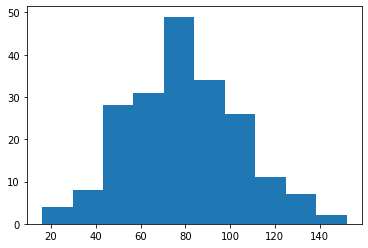

In [4]:
plt.hist(diffs['mc'])
plt.show()
plt.hist(diffs['cmps'])


### Expected $\sqrt n$ Random Runs

In [5]:
n = 10000
sqrtn = int(n ** 0.5)
reps = 200

RNG = random.Random(2348905734)
diffs = differences(reps, lambda: Inputs.random_runs(n, sqrtn, RNG))
print(diffs)
print(diffs['mc']  .describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75]))
print(diffs['cmps'].describe(percentiles=[0.01, 0.05, 0.1, .25, .5, .75]))

                  algo    cmps  cmps-powersort    input-hash      mc  \
0    timsort-powersort  3054.0         74054.0  6.644946e+18  3231.0   
1    timsort-powersort  2061.0         75134.0  4.226510e+18  2099.0   
2    timsort-powersort  1279.0         72777.0 -7.853696e+18   769.0   
3    timsort-powersort  1300.0         74309.0  4.236634e+16  1171.0   
4    timsort-powersort  4726.0         75889.0 -1.415891e+17  4843.0   
..                 ...     ...             ...           ...     ...   
195  timsort-powersort  4873.0         75431.0  8.530472e+18  4833.0   
196  timsort-powersort  3200.0         74513.0 -5.030300e+18  3975.0   
197  timsort-powersort  1888.0         76016.0  3.950142e+18  3994.0   
198  timsort-powersort   506.0         73322.0  5.859866e+18   451.0   
199  timsort-powersort  2423.0         75438.0 -9.150634e+18  3032.0   

     mc-powersort  
0         62713.0  
1         63630.0  
2         62186.0  
3         62945.0  
4         63879.0  
..            .

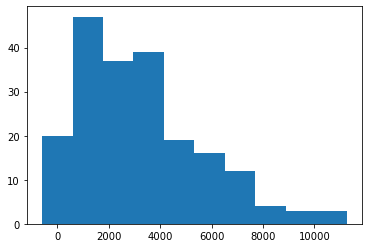

(array([21., 23., 42., 39., 26., 21., 10.,  7.,  7.,  4.]),
 array([-287. ,  409.9, 1106.8, 1803.7, 2500.6, 3197.5, 3894.4, 4591.3,
        5288.2, 5985.1, 6682. ]),
 <a list of 10 Patch objects>)

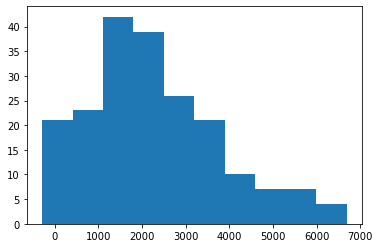

In [6]:
plt.hist(diffs['mc'])
plt.show()
plt.hist(diffs['cmps'])

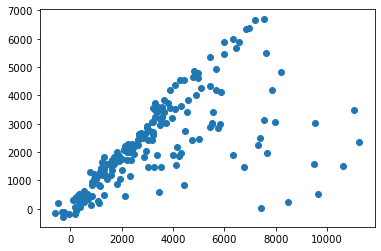

In [7]:
plt.scatter('mc', 'cmps', data = diffs)